In [1]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import argparse
import matplotlib.colors as colors

In [2]:
from matplotlib import ticker
import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [3]:
#input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_30k_to_39k_level6_cleanedpulses_transformed_IC19lt500_CC_all_start_all_end_flat_499bins_100000evtperbin_file00.hdf5'
#input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_03k_level6.zst_cleanedpulses_transformed_IC19_nocut8hitslt500_CC_all_start_all_end_flat_499bins_40000evtperbin.hdf5'
#input_file = '/mnt/scratch/micall12/training_files/single_file/140000/NuMu_genie_149999_000010_level6.zst_cleanedpulses_transformed_IC19.hdf5'
### Import Files ###
f = h5py.File(input_file, 'r')
features_DC = f['features_DC'][:]
features_IC = f['features_IC'][:]
labels = f['labels'][:]
#reco = f['reco_labels'][:]
weights = f['weights'][:]
stats = f['initial_stats'][:]
num_pulses = f['num_pulses_per_dom'][:]
f.close()
del f

KeyError: "Unable to open object (object 'features_DC' doesn't exist)"

In [5]:
#input_file = '/mnt/research/IceCube/jmicallef/DNN_files/old_files/extended_apr/NuMu_genie_149999_level6_cleanedpulses_tranformed_IC19_E1to500_CC_all_start_all_end_flat_499bins_20000evtperbin_file00.hdf5'
#input_file='/mnt/research/IceCube/jmicallef/DNN_files/NuMu_genie_149999_final_level6_cleanedpulses_transformed_IC19_nocut8hits_E1to500_CC_all_start_all_end_1minDOMflat_499bins_20000evtperbin_file00.hdf5'
#input_file = '/mnt/research/IceCube/jmicallef/DNN_files/oscNext_level6_flercnn_pass2.129999_1.4mill_149999_2.8mill_130000_2.8mill.cleanedpulses_transformed_IC19.no_cuts_file01.hdf5'
input_file = "/mnt/scratch/micall12/training_files/batch_file/oscNext_level6_flercnn_pass2.120000_00h_140000_12h-14h_130000_00-05h.cleanedpulses_transformed_IC19.no_cuts_file00.hdf5"
### Import Files ###
f = h5py.File(input_file, 'r')
features_DC = f['X_train_DC'][:]
features_IC = f['X_train_IC'][:]
labels = f['Y_train'][:]
#reco = f['reco_labels'][:]
#stats = f['initial_stats'][:]
#num_pulses = f['num_pulses_per_dom'][:]
f.close()
del f

In [6]:
PID = labels[:,9]
true_isNuMu = PID == 14
true_isNuE = PID == 12
true_isNu = numpy.logical_or(true_isNuMu, true_isNuE)
true_isMuon = PID == 13
energy = labels[:,0]*100
zenith = labels[:,12]
coszen = numpy.cos(zenith)
print(sum(true_isNuMu),sum(true_isNuE),sum(true_isMuon),len(PID))

164947 55957 165071 385975


In [4]:
charge_DC = features_DC[:,:,:,0] > 0
charge_IC = features_IC[:,:,:,0] > 0
charge_DC.shape
DC_flat = numpy.reshape(charge_DC,[features_DC.shape[0],480])
IC_flat = numpy.reshape(charge_IC,[features_IC.shape[0],1140])
DOMs_hit_DC = numpy.sum(DC_flat,axis=-1)
DOMs_hit_IC = numpy.sum(IC_flat,axis=-1)
DOMs_hit = DOMs_hit_DC + DOMs_hit_IC
DOMs_hit.shape

(403305,)

In [6]:
print(DOMs_hit[:10])
print(DOMs_hit.shape[0]*18)

[ 38   9  67  16  44  39 138  14  44  10]
7259490


In [37]:
threshold = 4
check_hit = DOMs_hit >= threshold
check_hit_DC = DOMs_hit_DC >= threshold
check_hit_IC = DOMs_hit_IC >= threshold
below_threshold = check_hit == 0
print(sum(check_hit)/len(check_hit))
print(sum(check_hit_DC)/len(check_hit_DC))
print(sum(check_hit_IC)/len(check_hit_IC))

1.0
0.9927945351532959
0.8632399796679932


In [38]:
mask_large = check_hit
mask_small = below_threshold
true_energy1 = numpy.array(labels[:,0])*100
weights1 = numpy.ones(len(true_energy1))

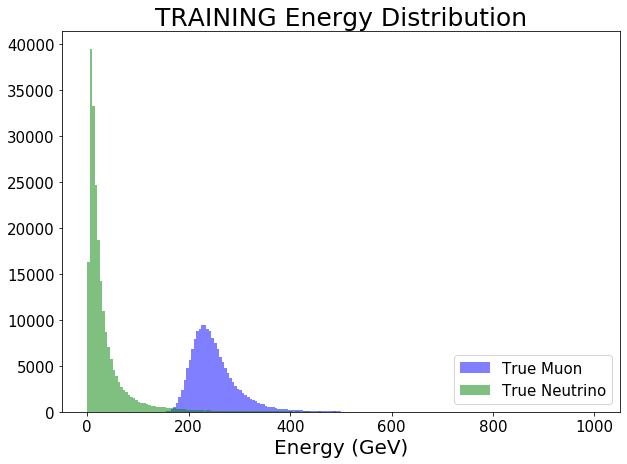

In [7]:
bins = 200 #10**numpy.linspace(0,2.2,50)
amin=0
amax = 1000
plt.figure(figsize=(10,7))
plt.hist(energy[true_isMuon], color="blue",
         label="True Muon",bins=bins,range=[amin,amax],
         weights=None,alpha=0.5)
plt.hist(energy[true_isNu], color="green",
         label="True Neutrino",bins=bins,range=[amin,amax],
         weights=None,alpha=0.5)
#plt.hist([cnn_energy1[mask_large],cnn_energy1[mask_small]], color=["blue","cyan"],stacked=True,
#         label=["CNN events > %i DOMs"%threshold,"CNN events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
#         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5)
#plt.yscale("log")
#plt.xscale('log')
plt.title("TRAINING Energy Distribution",fontsize=25)
plt.xlabel("Energy (GeV)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right',fontsize=15)

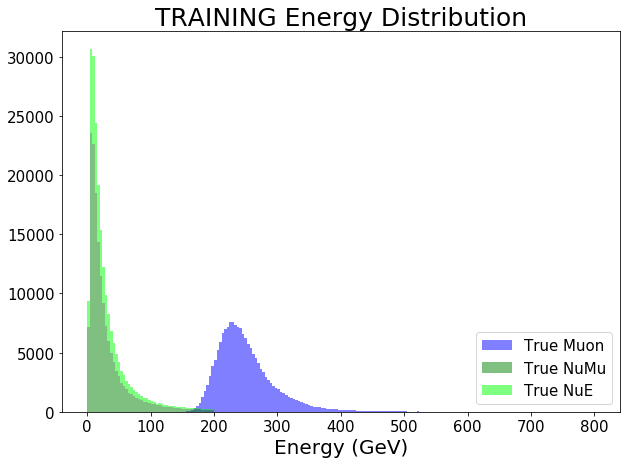

In [8]:
bins = 200 #10**numpy.linspace(0,2.2,50)
amin=0
amax = 800
plt.figure(figsize=(10,7))
plt.hist(energy[true_isMuon], color="blue",
         label="True Muon",bins=bins,range=[amin,amax],
         weights=None,alpha=0.5)
plt.hist([energy[true_isNuMu],energy[true_isNuE]], color=["green","lime"],
         label=["True NuMu","True NuE"],bins=50,range=[0,200],stacked=True, alpha=0.5)
#plt.hist([cnn_energy1[mask_large],cnn_energy1[mask_small]], color=["blue","cyan"],stacked=True,
#         label=["CNN events > %i DOMs"%threshold,"CNN events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
#         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5)
#plt.yscale("log")
#plt.xscale('log')
plt.title("TRAINING Energy Distribution",fontsize=25)
plt.xlabel("Energy (GeV)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right',fontsize=15)

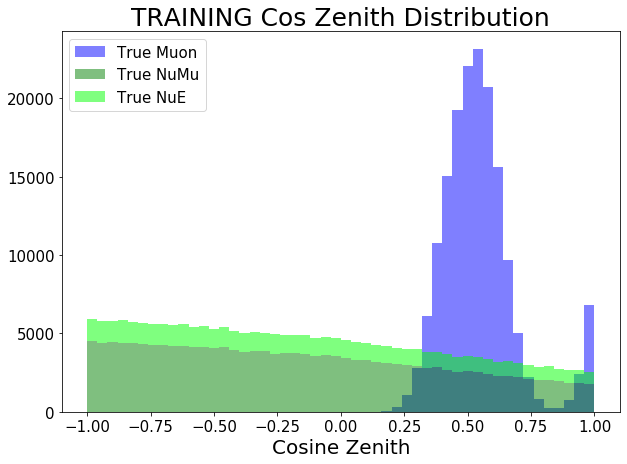

In [9]:
bins = 50 #10**numpy.linspace(0,2.2,50)
amin=-1
amax = 1
plt.figure(figsize=(10,7))
plt.hist(coszen[true_isMuon], color="blue",
         label="True Muon",bins=bins,range=[amin,amax],
         weights=None,alpha=0.5)
plt.hist([coszen[true_isNuMu],coszen[true_isNuE]], color=["green","lime"],
         label=["True NuMu","True NuE"],bins=bins,range=[amin,amax],stacked=True, alpha=0.5)
#plt.hist([cnn_energy1[mask_large],cnn_energy1[mask_small]], color=["blue","cyan"],stacked=True,
#         label=["CNN events > %i DOMs"%threshold,"CNN events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
#         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5)
#plt.yscale("log")
#plt.xscale('log')
plt.title("TRAINING Cos Zenith Distribution",fontsize=25)
plt.xlabel("Cosine Zenith",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',fontsize=15)

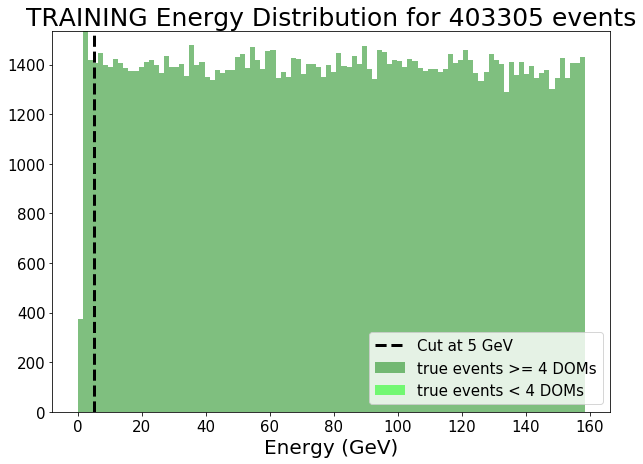

In [39]:
bins = 100 #10**numpy.linspace(0,2.2,50)
amin=0
amax = 10**2.2
plt.figure(figsize=(10,7))
plt.hist([true_energy1[true_isNuMu], true_energy1[mask_small]], color=["green","lime"],
         label=["true events >= %i DOMs"%threshold,"true events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5,stacked=True)
#plt.hist([cnn_energy1[mask_large],cnn_energy1[mask_small]], color=["blue","cyan"],stacked=True,
#         label=["CNN events > %i DOMs"%threshold,"CNN events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
#         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5)
#plt.yscale("log")
#plt.xscale('log')
plt.title("TRAINING Energy Distribution for %s events"%len(true_energy1),fontsize=25)
plt.xlabel("Energy (GeV)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(5,linewidth=3,linestyle="--",color='k',label="Cut at 5 GeV")
plt.legend(loc='lower right',fontsize=15)

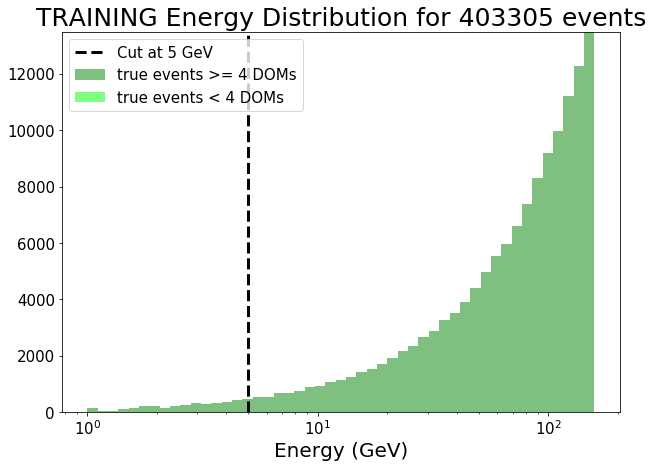

In [40]:
bins = 10**numpy.linspace(0,2.2,50)
amin=0
amax = 10**2.2
plt.figure(figsize=(10,7))
plt.hist([true_energy1[mask_large], true_energy1[mask_small]], color=["green","lime"],
         label=["true events >= %i DOMs"%threshold,"true events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5,stacked=True)
#plt.hist([cnn_energy1[mask_large],cnn_energy1[mask_small]], color=["blue","cyan"],stacked=True,
#         label=["CNN events > %i DOMs"%threshold,"CNN events < %i DOMs"%threshold],bins=bins,range=[amin,amax],
#         weights=[weights1[mask_large],weights1[mask_small]],alpha=0.5)
#plt.yscale("log")
plt.xscale('log')
plt.title("TRAINING Energy Distribution for %s events"%len(true_energy1),fontsize=25)
plt.xlabel("Energy (GeV)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(5,linewidth=3,linestyle="--",color='k',label="Cut at 5 GeV")
plt.legend(loc='upper left',fontsize=15)

In [ ]:
isCC = numpy.array(labels[:,11]) == 1
true_energy1 = numpy.array(labels[:,0])*100
weights1 = numpy.ones(len(true_energy1))
mask= isCC
mask_large = mask & check_hit
mask_small = mask & below_threshold

In [48]:
numpy.where(check_hit==False)

(array([  14,  114,  140,  176,  197,  243,  263,  275,  280,  300,  360,
         365,  387,  394,  395,  656, 1323]),)

In [49]:
count_outside = stats[:,0]
charge_outside = stats[:,1]
count_inside = stats[:,2]
charge_inside = stats[:,3]
count_orig_inside = stats[:,4]
charge_orig_inside = stats[:,5]
fraction_count_inside = count_inside/(count_outside + count_inside)
fraction_charge_inside = charge_inside/(charge_outside + charge_inside)

In [50]:
check_index = 14
print(weights[check_index][1],weights[check_index][2],count_inside[check_index],count_orig_inside[check_index],count_outside[check_index],DOMs_hit[check_index])
print(numpy.where(count_inside==5),count_outside[check_index])

4294967295.0 610.0 7.0 7.0 0.0 6
(array([], dtype=int64),) 0.0


In [ ]:
#input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_07k_level6.zst_cleanedpulses_transformed_IC19lt500_CC_all_start_all_end_flat_499bins_250000evtperbin.hdf5'
input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_00k_to_29k_level6_cleanedpulses_transformed_IC19lt500_CC_all_start_all_end_flat_499bins_100000evtperbin_file04.hdf5'
f = h5py.File(input_file, 'r')
features_DC2 = f['features_DC'][:]
features_IC2 = f['features_IC'][:]
labels2 = f['labels'][:]
#reco = f['reco_labels'][:]
stats2 = f['initial_stats'][:]
num_pulses2 = f['num_pulses_per_dom'][:]
f.close()
del f

In [ ]:
labels = numpy.concatenate((labels,labels2))
stats = numpy.concatenate((stats,stats2))
num_pulses = numpy.concatenate((num_pulses,num_pulses2))

In [ ]:
#input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_09k_level6.zst_cleanedpulses_transformed_IC19lt500_CC_all_start_all_end_flat_499bins_250000evtperbin.hdf5'
input_file = '/mnt/scratch/micall12/training_files/batch_file/149999/NuMu_genie_149999_00k_to_29k_level6_cleanedpulses_transformed_IC19lt500_CC_all_start_all_end_flat_499bins_100000evtperbin_file01.hdf5'
f = h5py.File(input_file, 'r')
features_DC3 = f['features_DC'][:]
features_IC3 = f['features_IC'][:]
labels3 = f['labels'][:]
#reco = f['reco_labels'][:]
stats3 = f['initial_stats'][:]
num_pulses3 = f['num_pulses_per_dom'][:]
f.close()
del f

In [ ]:
labels = numpy.concatenate((labels,labels2,labels3))
stats = numpy.concatenate((stats,stats2,stats3))
num_pulses = numpy.concatenate((num_pulses,num_pulses2,num_pulses3))

In [ ]:
energy = labels[:,0]*100

In [ ]:
energy_cut = labels[:,0] < 0.3
print(sum(energy_cut)/len(energy_cut))

In [ ]:
labels = labels[energy_cut]
stats = stats[energy_cut]
num_pulses = num_pulses[energy_cut]

In [ ]:
# reco: (energy, zenith, azimuth, time, x, y, z) 
# stats: (count_outside, charge_outside, count_inside, charge_inside) 
# num_pulses: [ string num, dom index, num pulses]

In [ ]:
events = stats.shape[0]
print(events)
print(stats.shape,num_pulses.shape)

In [ ]:
max(energy)

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Energy Distribution")
plt.hist(energy,bins=30,color='b')
plt.xlabel("Energy (GeV)")

In [ ]:
max_per_bin = 5000
count_energy = numpy.zeros(30)
emin = 1
bin_size = 1
keep_index = [False]*len(energy)

for index,e in enumerate(energy):
    e_bin = int((e-emin)/float(bin_size))
    if count_energy[e_bin] < max_per_bin:
        keep_index[index] = True
        count_energy[e_bin] += 1

In [ ]:
plt.figure(figsize=(10,7))
plt.title("Energy Distribution",fontsize=25)
plt.hist(energy[keep_index],bins=30,color='b')
plt.xlabel("Energy (GeV)",fontsize=20)
print(sum(keep_index))

In [ ]:
count_outside = stats[:,0]
charge_outside = stats[:,1]
count_inside = stats[:,2]
charge_inside = stats[:,3]
fraction_count_inside = count_inside/(count_outside + count_inside)
fraction_charge_inside = charge_inside/(charge_outside + charge_inside)

In [ ]:
DOMs_hit = numpy.zeros(events)
for i in range(events):
    hit = num_pulses[i,:,:,0].flatten() > 0
    DOMs_hit[i] = sum(hit)

In [ ]:
mask = keep_index

plt.figure(figsize=(10,8))
plt.title("Energy vs. nHits",fontsize=25)
plt.hist2d(energy[mask],count_inside[mask],bins=[20,50],range=[[0,20],[0,50]],cmap='viridis_r',cmin=0.000001) #,norm=colors.LogNorm())
cbat = plt.colorbar()
plt.xlabel("Energy (GeV)",fontsize=20)
plt.ylabel("Number Hits in CNN Strings", fontsize=20)

plt.figure(figsize=(10,8))
plt.title("Energy vs. Charge",fontsize=25)
plt.hist2d(energy[mask],charge_inside[mask],bins=[20,60],range=[[0,20],[0,60]],cmap='viridis_r',cmin=0.000001) #,norm=colors.LogNorm())
cbat = plt.colorbar()
plt.xlabel("Energy (GeV)",fontsize=20)
plt.ylabel("Sum of Charge in CNN Strings (p.e.)", fontsize=20)

plt.figure(figsize=(10,8))
plt.title("Energy vs. nDOMs",fontsize=25)
plt.hist2d(energy[mask],DOMs_hit[mask],bins=[20,30],range=[[0,20],[0,30]],cmap='viridis_r',cmin=0.000001) #,norm=colors.LogNorm())
cbat = plt.colorbar()
plt.xlabel("Energy (GeV)",fontsize=20)
plt.ylabel("Number of Hit DOMs", fontsize=20)

In [ ]:
plt.figure()
plt.title("Fraction of # pulses inside subset strings")
plt.hist(fraction_count_inside,bins=50,alpha=0.5);
plt.xlabel("# pulses inside subset strings / total # pulses in event")

plt.figure()
plt.title("Fraction of charge inside subset strings")
plt.hist(fraction_charge_inside,bins=50,alpha=0.5);
plt.xlabel("charge recorded inside subset strings / total charge recorded in event")

In [ ]:

plt.title("Number of pulses > 0 on ALL DOMS for ALL events")
plt.hist(num_pulses_all[gt0],bins=15,alpha=0.5);
plt.xlabel("# pulses per dom")
plt.yscale('log')

In [ ]:
plt.figure()
for i in range(0,10):
    num_pulses_one_evt = num_pulses[i,:,:,0].flatten()
    gt0 = num_pulses_one_evt > 0
    plt.hist(num_pulses_one_evt[gt0],bins=5,alpha=0.5);
plt.title("Number of pulses > 0 on ALL DOMS per event")
plt.xlabel("# pulses per dom")
plt.yscale('log')

In [ ]:
large_mask = num_pulses_all > 20
large_num = sum(num_pulses_all[large_mask])
fraction_large = large_num/len(num_pulses_all)

In [ ]:
print(large_num, len(num_pulses_all),fraction_large*100)

In [ ]:
num_pulses.index(100)

In [ ]:
def find_large_events(pulse_array,large_num):
    unique_event = []
    num_not_unique = 0
    for i in range(0,pulse_array.shape[0]):
        not_unique =0
        for j in range(0,pulse_array.shape[1]):
            for k in range(0,pulse_array.shape[2]):
                for l in range(0,pulse_array.shape[3]):
                    if pulse_array[i,j,k,l] > large_num:
                        if i not in unique_event:
                            unique_event.append(i)
                        else:
                            not_unique +=1
        if not_unique > 0:
            #print("Event %i has %i large events"%(i,(not_unique+1)))
            num_not_unique +=1
    return unique_event, num_not_unique
large_20, not_unique_20 = find_large_events(num_pulses,20) 

In [ ]:
print(not_unique_20)
print(len(large_20))
print(len(large_20)/float(len(num_pulses_all))*100)

In [ ]:
large_10, not_unique_10 = find_large_events(num_pulses,10) 

In [ ]:
print(not_unique_10)
print(len(large_10))
print(len(large_10)/float(len(num_pulses_all))*100)

In [ ]:
large_5, not_unique_5 = find_large_events(num_pulses,5) 
print(not_unique_5)
print(len(large_5))
print(len(large_5)/float(len(num_pulses_all))*100)